## TCGA

## FPKM (Fragments Per Kilobase of transcript per Million)

When you have paired-end RNA-seq data, you count **fragments** (read pairs) rather than individual reads. FPKM normalizes for sequencing depth and gene length just like RPKM, but uses fragments.

1. **Sequencing depth**: samples sequenced to different depths get scaled so total fragment count differences don’t bias comparisons.  
2. **Gene length**: longer transcripts produce more fragments just by being longer, so we divide out transcript length.

The normalized \((i, j)\) FPKM value, where \(i\) is a gene and \(j\) is a sample, can be written two ways:

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j}}
     {\,l_i \cdot \sum_{k} f_{k,j}\,}
\times 10^6
$$

or equivalently

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j} \;\times\; 10^9}
     {\,N_j \;\times\; L_i\,}
$$

<!-- blank line above is important -->
- **\(f_{i,j}\)** is the raw fragment count for gene \(i\) in sample \(j\).  
- **\(l_i\)** is the length of gene \(i\) in kilobases (kb).  
- **\(\sum_{k} f_{k,j}\)** is the total number of fragments in sample \(j\).  
- **\(N_j\)** is the total fragments sequenced in sample \(j\).  
- **\(L_i\)** is the length of gene \(i\) in bases.  


In [2]:
import pandas as pd
import numpy as np

# mRNA seq
# Expression Data with gene as index and cells/samples as columns
data_mrna_seq_rpkm = pd.read_csv('tcga_data/data_mrna_seq_fpkm.txt',
                    sep = '\t',
                    comment = '#')

data_mrna_seq_rpkm.set_index('Hugo_Symbol',inplace=True)

# Merge with mean duplicated rows
data_mrna_seq_rpkm = data_mrna_seq_rpkm.groupby(data_mrna_seq_rpkm.index).mean()

In [3]:
data_mrna_seq_rpkm.head()

,SP89389,SP21193,SP13206,SP103623,SP32742,SP111095,SP8394,SP87446,SP36586,SP123902,...,SP15656,SP123888,SP59420,SP116679,SP1377,SP16269,SP122676,SP88776,SP64546,SP21057
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
CRIPTOP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG,0.409799,0.022891,0.082842,0.075852,0.149032,0.023175,0.119738,0.112135,0.059707,0.021957,...,0.587783,0.029553,0.229903,0.315114,0.034723,0.656322,0.476527,0.079750,0.091196,0.013030
A1BG-AS1,1.567399,0.196993,0.376265,0.271986,1.035252,0.132957,1.357942,0.753626,0.102765,0.110224,...,3.424922,0.378225,1.741374,1.946055,0.946255,3.781337,1.074688,0.554893,0.433442,0.074755
A1CF,0.043229,0.885682,0.000000,0.715912,0.010971,2.296044,0.027879,0.000000,1.656342,0.016029,...,0.049806,0.004742,0.008621,0.013397,0.000000,0.012708,0.000000,0.000708,0.001492,3.038471
A2M,30.816782,57.959083,37.798822,224.339366,23.396122,14.215019,53.002411,47.629206,51.087998,39.520998,...,0.023052,33.442775,53.716981,80.680141,23.491400,0.048657,121.201090,41.204146,33.427796,28.183744


In [4]:
#--------Mut query----------
# Description:
# Data telling  which sample is mutated and not-mutated
mutations= pd.read_csv('tcga_data/mutations.txt',
                    sep = '\t',
                    comment = '#')
mutations.set_index('SAMPLE_ID',inplace=True)

In [5]:
mutations.head()

,STUDY_ID,TP53
SAMPLE_ID,,
SP107436,pancan_pcawg_2020,WT
SP107435,pancan_pcawg_2020,WT
SP107407,pancan_pcawg_2020,WT
SP107406,pancan_pcawg_2020,WT
SP107405,pancan_pcawg_2020,WT


## Why predict on just the five Variant_Type classes

We focus on SNP, DNP, ONP, INS, and DEL because:

1. Biological clarity: these five labels describe the fundamental mutation mechanism, single-base or multi-base changes, insertions, and deletions, so the model learns clear patterns.  
2. Balanced data: each Variant_Type occurs often enough to give the model enough examples, while the detailed Variant_Classification labels are very uneven and would leave some classes too small to learn.  
3. Reduced complexity: Variant_Classification depends on gene structure and reading frame (for example a SNP can be silent or missense depending on codon), which our sequence‐only model cannot infer without extra annotation.  
4. Modular workflow: once the model tags a variant as INS or DEL, we can apply separate rules or a second model to predict functional impact, keeping each step simpler and more reliable.  


In [6]:
# ------Mut ALL-----------
# Dataset containing mutation classes for all genes, it only contains mutated samples
data_mutations = pd.read_csv('tcga_data/data_mutations.txt',
                    sep = '\t',
                    comment = '#')

# Extract TP53 from all genes
data_mutations = data_mutations[data_mutations['Hugo_Symbol'] == 'TP53']

In [7]:
data_mutations.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,Annotation_Status,DNA_VAF
54,TP53,7157.0,NaN,GRCh37,17,7577058,7577058,+,stop_gained,Nonsense_Mutation,...,ENST00000269305.4:c.880G>T,p.Glu294Ter,p.E294*,ENST00000269305,NM_001126112.2,294.0,Gag/Tag,0,SUCCESS,0.8846
1117,TP53,7157.0,NaN,GRCh37,17,7578475,7578475,+,missense_variant,Missense_Mutation,...,ENST00000269305.4:c.455C>T,p.Pro152Leu,p.P152L,ENST00000269305,NM_001126112.2,152.0,cCg/cTg,0,SUCCESS,0.1154
2024,TP53,7157.0,NaN,GRCh37,17,7577560,7577560,+,missense_variant,Missense_Mutation,...,ENST00000269305.4:c.721T>C,p.Ser241Pro,p.S241P,ENST00000269305,NM_001126112.2,241.0,Tcc/Ccc,0,SUCCESS,0.9375
2480,TP53,7157.0,NaN,GRCh37,17,7578540,7578548,+,inframe_deletion,In_Frame_Del,...,ENST00000269305.4:c.382_390del,p.Pro128_Leu130del,p.P128_L130del,ENST00000269305,NM_001126112.2,128.0,CCTGCCCTC/-,0,SUCCESS,0.8461
2570,TP53,7157.0,NaN,GRCh37,17,7577580,7577580,+,missense_variant,Missense_Mutation,...,ENST00000269305.4:c.701A>G,p.Tyr234Cys,p.Y234C,ENST00000269305,NM_001126112.2,234.0,tAc/tGc,0,SUCCESS,0.4524


In [8]:
unique_labels = data_mutations['Variant_Classification'].unique()
print(unique_labels)

['Nonsense_Mutation' 'Missense_Mutation' 'In_Frame_Del' 'Frame_Shift_Del'
 'Splice_Site' 'Frame_Shift_Ins' 'Splice_Region' 'In_Frame_Ins' 'Silent']


In [9]:
# Remove unwanted information
data_mutations = data_mutations[['Tumor_Sample_Barcode', 'Variant_Type']]
data_mutations.set_index('Tumor_Sample_Barcode', inplace=True)
# There are repetitions of my mutation type (Variant_Type)
# if there is the same sample with different Variant_Type it should be removed
variant_check = data_mutations.groupby(data_mutations.index)["Variant_Type"].nunique()

In [10]:
data_mutations.head()

,Variant_Type
Tumor_Sample_Barcode,
SP101724,SNP
SP22031,SNP
SP59388,SNP
SP94588,DEL
SP7692,SNP


In [12]:
class_names = ['WT','SNP','DNP','DEL','INS']
code = {"WT": 0, "SNP": 1, "DNP": 2, "DEL": 3, "INS": 4}
variant_map = data_mutations['Variant_Type'].to_dict()

class_counts = {
    "WT": 0,
    "SNP": 0,
    "DEL": 0,
    "INS": 0,
    "DNP": 0
}

for sample_id, mut_type in mutations['TP53'].items():
    if mut_type == 'WT':
        class_counts[mut_type] += 1
    else:
        class_counts[variant_map[sample_id]] += 1

print(class_counts)


{'WT': 1781, 'SNP': 737, 'DEL': 111, 'INS': 43, 'DNP': 11}


In [13]:
data_t = data_mrna_seq_rpkm.T

data_t.head()

Hugo_Symbol,CRIPTOP1,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,...,snoZ178,snoZ185,snoZ247,snoZ278,snoZ40,snoZ5,snoZ6,snosnR60_Z15,snosnR66,yR211F11.2
SP89389,0.0,0.409799,1.567399,0.043229,30.816782,0.293354,0.312641,0.000000,0.146655,0.024311,...,0.0,0.0,0.0,0.0,0.0,12.87572,0.085771,0.0,0.0,0.000000
SP21193,0.0,0.022891,0.196993,0.885682,57.959083,0.125789,0.006278,0.000000,0.059391,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP13206,0.0,0.082842,0.376265,0.000000,37.798822,0.056904,1.130378,0.000000,0.035823,0.026723,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP103623,0.0,0.075852,0.271986,0.715912,224.339366,1.493611,0.114422,0.000000,0.000000,0.179434,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP32742,0.0,0.149032,1.035252,0.010971,23.396122,0.235518,29.877306,0.051798,0.030327,0.045247,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.156084,0.0,0.0,0.020183


In [14]:
# Target vector
y = []

# Data matrix
X_rows = []
sample_names = []

c = 0
# Iterate over each mutation record to build the data matrix
for sample_id, mut_type in mutations['TP53'].items():
    if (sample_id in data_t.index):
        # grab the full row from data_t and store it
        X_rows.append(data_t.loc[sample_id].values)
        sample_names.append(sample_id)
        if mut_type == 'WT':
            y.append(code['WT'])
        else:
            y.append(code[variant_map[sample_id]])
    else:
        c += 1

# build a new DataFrame X from the collected rows
X = pd.DataFrame(
    X_rows,
    index=sample_names,
    columns=data_t.columns
)

y = np.array(y)

print(f"Number of samples discarded: {c}")
print(f"Final number of samples available: {X.shape[0]}")

Number of samples discarded: 1692
Final number of samples available: 991


In [15]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (991, 55851)
y shape: (991,)


**Train - Test split (90% - 10%)**

In [16]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

print(f"Train shape:\n\tX_train: {X_train_np.shape}\n\ty_train: {y_train_np.shape}")
print(f"Test shape:\n\tX_test: {X_test_np.shape}\n\ty_test: {y_test_np.shape}")

Train shape:
	X_train: (891, 55851)
	y_train: (891,)
Test shape:
	X_test: (100, 55851)
	y_test: (100,)


**Step 3: Model selection and Training**

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Instantiate the model
rf = RandomForestClassifier(
    n_estimators=500,      # you can tune this
    max_depth=None,        # full depth; you can limit for speed/regularization
    random_state=42,
    n_jobs=-1              # use all cores
)

In [20]:
# Train
rf.fit(X_train_np, y_train_np)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [21]:
# Predict
y_pred = rf.predict(X_test_np)

## Evaluation metrics

**Accuracy**: the fraction of total samples correctly predicted (both WT and mutated). Good for a quick overview.  

In [22]:
from sklearn.metrics import accuracy_score

# y_test_np are your true labels 
# y_pred your predictions
acc = accuracy_score(y_test_np, y_pred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 85.00%


In [23]:
# Precision / Recall / F1 per class, plus weighted averages
print("Precision, recall, F1-score per class and weighted avg:")
print(classification_report(
    y_test_np,
    y_pred,
    labels=[0,1,2,3,4],
    target_names=class_names,
    digits=2
))

Precision, recall, F1-score per class and weighted avg:
              precision    recall  f1-score   support

          WT       0.88      0.98      0.93        59
         SNP       0.79      0.82      0.81        33
         DNP       0.00      0.00      0.00         1
         DEL       0.00      0.00      0.00         5
         INS       0.00      0.00      0.00         2

    accuracy                           0.85       100
   macro avg       0.33      0.36      0.35       100
weighted avg       0.78      0.85      0.81       100



/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lorenzoturiano/Bocconi/ML-lab/ml_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

**Confusion matrix**: a table of
* **True Positives** (TP): mutated correctly called mutated
* **True Negatives** (TN): WT correctly called WT
* **False Positives** (FP): WT called mutated
* **False Negatives** (FN): mutated called WT

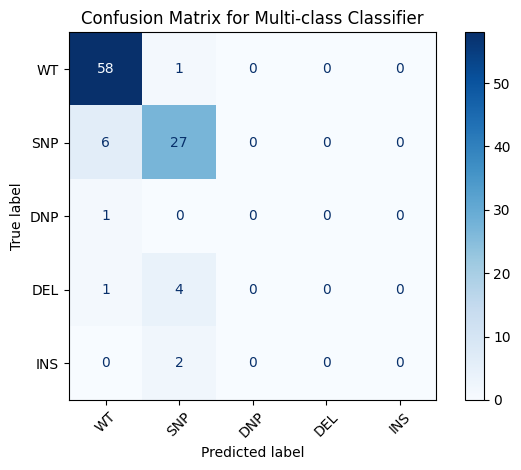

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for all five classes
cm = confusion_matrix(y_test_np, y_pred, labels=[0,1,2,3,4])

# Define the class names in the same order as their codes
class_names = ['WT', 'SNP', 'DNP', 'DEL', 'INS']

# Create and plot the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-class Classifier')
plt.tight_layout()
plt.show()